## Visualisation

Now that we have collected all the necessary data we will try to visualise the results. We will use `Folium` to see the results on a map.

The data we have at our disposal is the following :

* `ch-cantons.topojson.json` : A topoJSON file which shows __borders between the 26 swiss cantons__.
* `all_cantons.p` : A pickle containing the __grant amounts for each canton__.
* `uni_geo_infos.p`: A pickle containing the __locations of all the universities__ found in the P3 database

We will start by importing the necessary tools :

In [403]:
%matplotlib inline

import folium # For visualisation
import pickle # For importing data
import seaborn as sns
sns.set_context('notebook')

# Data files
canton_overlay   = 'ch-cantons.topojson.json'
grants_by_canton = 'all_cantons.p'
uni_locations    = 'uni_geo_infos.p'

Let's load a map of Switzerland through `folium`, scaling it to see the entire country.

In [404]:
ch_center_loc = [46.92287,8.3829913] # Empirical "center" of Switzerland
map_ch = folium.Map(location=ch_center_loc, zoom_start=8)
map_ch.save('1_ch.html')

# You can view the map [here](https://rawgit.com/romac/ADAHomeworks/master/03%20-%20Interactive%20Viz/1_ch.html)

Now we will add an overlay with all the cantons, thanks to the topoJSON file.

In [405]:
folium.TopoJson(open(canton_overlay),
                'objects.cantons',
                name='topojson'
               ).add_to(map_ch)
map_ch.save('2_ch_canton_overlay.html')
map_ch

# You can view the map [here](https://rawgit.com/romac/ADAHomeworks/master/03%20-%20Interactive%20Viz/2_ch_canton_overlay.html)

We can now visualise the grant amounts by canton, by loading the processed data and displaying it in a __Choropleth map__. Note that the values displayed are in **MCHF**.

In [406]:
# Load the data
grants_by_canton_data = pickle.load(open(grants_by_canton,'rb')).reset_index()

# Plot a Choropleth map
cols = ['Canton', 'Approved Amount'] # Columns of interest
color_map = 'YlOrRd'                 # Color Map used, Yellow for low values, Red for high
scale = [0, 1, 10, 100, 1000, 5000]  # Custom semi-log scale for better visualisation
legend_str = 'Grant amount (MCHF)'   # Legend title

map_ch.choropleth(
    geo_path=canton_overlay, 
    data=wc,
    columns=cols,
    topojson='objects.cantons',
    key_on='feature.id',
    fill_color=color_map,
    fill_opacity=0.7, 
    line_opacity=0.5,
    threshold_scale=scale,
    legend_name=legend_str,
    reset=True
)
map_ch.save('3ch_grant_overlay.html')
map_ch

# You can view the map [here](https://rawgit.com/romac/ADAHomeworks/master/03%20-%20Interactive%20Viz/3ch_grant_overlay.html)

We will now add the universities on the map.

In [407]:
# Load the data
unis = pickle.load(open(uni_locations,'rb'))

# Iterate over the dict and add a marker for each university
for key, val in unis.items():
    if val is not None:
        popup_str = key
        folium.Marker([val['location']['lat'], val['location']['lng']], popup=popup_str).add_to(map_ch)

In [408]:
map_ch.save('4_ch_canton_overlay_with_markers.html')
map_ch

# You can view the map [here](https://rawgit.com/romac/ADAHomeworks/master/03%20-%20Interactive%20Viz/4_ch_canton_overlay_with_markers.html)

---

# BONUS : Rostigraben

We will try to visualise the disparity on each side of the Röstigraben. First we will draw an approximate map of the cantons per language (approximate because cantons like Fribourg or Valais are bilingual and hence hard to seperate visually. Hence we made an **arbitrary** choice of considering Fribourg as German-speaking and Valais as French-speaking).

Let's start by mapping each canton to a language.

In [409]:
import pandas as pd

# Language assignements for visualisation on a map
DE = 0
FR = 1
IT = 2

# The canton to language mapping
cantons_lang = {
    'ZH' : DE,
    'BE' : DE,
    'LU' : DE,
    'UR' : DE,
    'SZ' : DE,
    'OW' : DE,
    'NW' : DE,
    'GL' : DE,
    'ZG' : DE,
    'FR' : DE,
    'SO' : DE,
    'BS' : DE,
    'BL' : DE,
    'SH' : DE,
    'AR' : DE,
    'AI' : DE,
    'SG' : DE,
    'GR' : DE,
    'AG' : DE,
    'TG' : DE,
    'TI' : IT,
    'VD' : FR,
    'VS' : FR,
    'NE' : FR,
    'GE' : FR,
    'JU' : FR
}

# Create a dataframe from this mapping
rosti_df = pd.DataFrame.from_dict(cantons_lang, orient='index')
rosti_df.reset_index(inplace=True)
rosti_df.rename(index=str, columns={'index': "Canton", 0:"Language"}, inplace=True)
rosti_df

,Canton,Language
0,NE,1
1,AI,0
2,AG,0
3,VD,1
4,VS,1
5,ZH,0
6,JU,1
7,OW,0
8,BL,0
9,SZ,0


Let's also provide a visualisation of our Rostigraben :

In [410]:
cantons_geo = './ch-cantons.topojson.json'
map_rosti = folium.Map(location=[46.92287,8.3829913], zoom_start=8)

map_rosti.choropleth(
    geo_path=cantons_geo, 
    data=rosti_pd,
    columns=['Canton', 'Language'],
    topojson='objects.cantons',
    key_on='feature.id',
    fill_color='YlOrRd',
    threshold_scale=[0, 1, 2],
    line_opacity=0.5
)
map_rosti

We also need the corresponding grant amounts for each canton. To do this we will join our previous "grant by canton" dataframe with the new "canton to language" dataframe.

In [411]:
rosti_amount = rosti_df.set_index('Canton').join(grants_by_canton_data.set_index('Canton')).drop(['index'], axis=1)
rosti_amount

,Language,Approved Amount
Canton,,
NE,1,398.615780
AI,0,0.000000
AG,0,115.268969
VD,1,2372.220567
VS,1,29.644090
ZH,0,3651.082929
JU,1,34.790345
OW,0,0.000000
BL,0,3.476142


We can now plot the amount of grant money received by each "language" (i.e., either side of the Rostigraben).

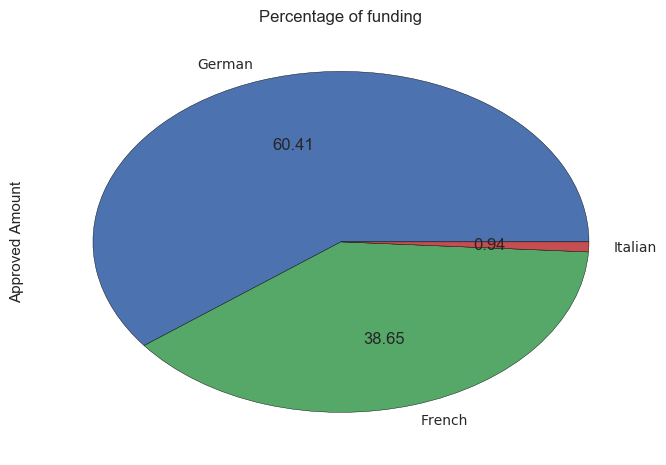

In [412]:
rosti_sum_by_lang = rosti_amount.groupby(['Language']).sum()['Approved Amount']
rosti_sum_by_lang.plot(kind='pie', labels=['German', 'French', 'Italian'], autopct='%.2f', title='Percentage of funding')